In [559]:
import numpy as np
import sys
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import interferometer as itf
sys.path.append('../') # Add parent directory to the system path
from boson_sampling_probabilities import output_probability
from simulation import run_interferom_simulation, dist_to_state

from numeric_truncated_unitaries import numeric_truncated_unitary
from direct_decomposition import compile_unitary, knit_qiskit_circuits, random_unitary, direct_decomposition
from random import random
from qiskit.quantum_info import Operator

In [560]:
theta_1 = np.pi/2 * random()
phi_1 = np.pi * random()
theta_2 = 0
phi_2 = 0
theta_3 = 0
phi_3 = 0

[
 Beam splitter between modes 1 and 2: 
 Theta angle: 0.61 
 Phase: 0.29, 
 Beam splitter between modes 2 and 3: 
 Theta angle: 0.00 
 Phase: 0.00, 
 Beam splitter between modes 1 and 2: 
 Theta angle: 0.00 
 Phase: 0.00]


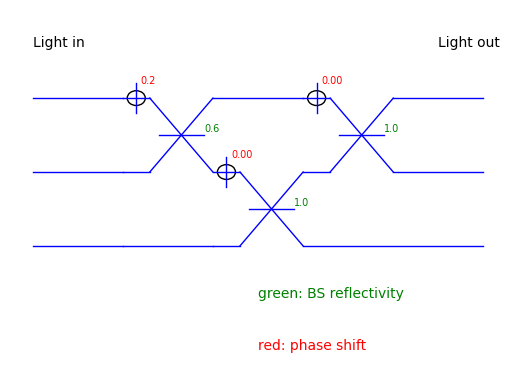

In [561]:
"""
Some notes:
    theta = 0 -> reflective.
    theta = pi/2 -> transparent
    R = 0 -> transparent
    R = 1 -> reflective
"""

I = itf.Interferometer()

BS1 = itf.Beamsplitter(1, 2, theta=theta_1, phi=phi_1)
BS2 = itf.Beamsplitter(2, 3, theta=theta_2, phi=phi_2)
BS3 = itf.Beamsplitter(1, 2, theta=theta_3, phi=phi_3)

I.add_BS(BS1)
I.add_BS(BS2)
I.add_BS(BS3)

print(I.BS_list)
I.draw()

In [562]:
# Debug:
print(theta_1)
print(theta_2)
print(theta_3)
print(phi_1)

0.6098179751377817
0
0
0.29040229566808506


In [563]:
def is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), np.conjugate(np.transpose(m)) @ m)

R=I.calculate_transformation()
print(R)
is_unitary(R)

[[ 0.78542824+0.23472598j -0.57271825+0.j          0.        +0.j        ]
 [ 0.54873783+0.16399083j  0.81975228+0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j        ]]


True

In [564]:
initial_dist = [1,0,0]
possible_dists = [[1,0,0], [0,1,0], [0,0,1]] # Every configuration of 1 photon in 3 modes

analytic_probs = dict()
for dist in possible_dists:
    assert(is_unitary(R))
    # prob = output_probability([1,0,0], dist, R)
    # This is what was going wrong I was putting in incorrect arguments
    # I was iterating over output distributions, not input distributions!
    prob = output_probability(initial_dist, dist, R)
    state = dist_to_state(dist)
    analytic_probs[state] = prob

print(analytic_probs)

{'100': 0.6719938011991593, '010': 0.32800619880084075, '001': 0.0}


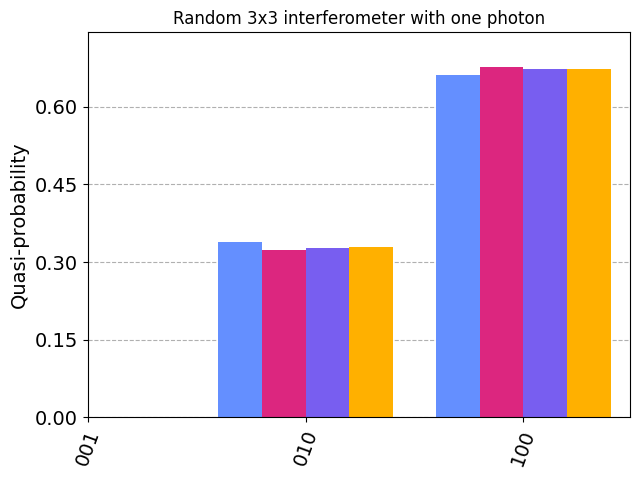

In [565]:
probs_1e3 = run_interferom_simulation(R, initial_dist, 1e3)
probs_1e4 = run_interferom_simulation(R, initial_dist, 1e4)
probs_1e5 = run_interferom_simulation(R, initial_dist, 1e5)

legend = ['Shots = 1e3','Shots = 1e4','Shots = 1e5', 'Analytic results']
plot_histogram([probs_1e3, probs_1e4, probs_1e5, analytic_probs], 
               title='Random 3x3 interferometer with one photon', bar_labels=False)

In [566]:
def zero_close_elements(matrix, threshold=1e-10):
    """
    Sets elements in the complex matrix to zero if their magnitude is close to zero.
    
    Parameters:
    matrix (np.ndarray): A 2D numpy array with complex numbers.
    threshold (float): A small threshold value to determine what is considered close to zero.
    
    Returns:
    np.ndarray: A matrix with elements close to zero set to exactly zero.
    """
    real_close_to_zero = np.abs(matrix.real) < threshold
    imag_close_to_zero = np.abs(matrix.imag) < threshold
    
    matrix.real[real_close_to_zero] = 0
    matrix.imag[imag_close_to_zero] = 0
    
    return matrix

In [571]:
print(I.calculate_transformation())

[[ 0.78542824+0.23472598j -0.57271825+0.j          0.        +0.j        ]
 [ 0.54873783+0.16399083j  0.81975228+0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          1.        +0.j        ]]


In [578]:
big_circ = direct_decomposition(I.calculate_transformation(), 1)
big_op = Operator(big_circ)
big_op = zero_close_elements(big_op.data)
for el in big_op[5]:
    print(el)

0j
0j
0j
(0.5727182542933662+0j)
0j
(0.7854282364324738-0.23472598197415806j)
0j
0j


In [569]:
from qiskit.quantum_info import Statevector

def custom_interferom_simulation(U, photon_config, num_shots):
    """
    Compile and run a quantum circuit corresponding to a linear interferometer with unitary U.

    U: Unitary matrix
    photon_config: The initial configuration (distribution) of photons.
        i.e. [5,7] means 5 photons in mode 0, 7 photon in mode 1.
    num_shots: The number of times the circuit is simulated
    """
    num_photons = sum(photon_config)
    num_modes = int(np.shape(U)[0])
    qubits_per_mode = int(np.ceil(np.log2(num_photons + 1)))
    num_qubits = qubits_per_mode * num_modes
    circuit = QuantumCircuit(num_qubits)
    
    initial_state = Statevector([0,0,0,0,1,0,0,0])
    circuit.initialize(initial_state)
    interferom = direct_decomposition(U, num_photons)
    circuit.compose(interferom, qubits=list(range(num_qubits)), inplace=True)
    circuit.measure_all()

    simulator = AerSimulator()
    circuit = transpile(circuit, simulator) # TODO, this big circuit can be further optimized
    result = simulator.run(circuit, shots=num_shots).result()
    counts = result.get_counts(circuit)

    # Convert counts to probabilities
    for key in counts.keys():
        counts[key] = counts[key] / num_shots

    # def estimate_error(probs, m):
    #     for measurement in probs.keys():
    #         output_config = reverse_blocks(measurement, m)
    #         output_probability(photon_config, output_config, U)
    #     return

    return counts

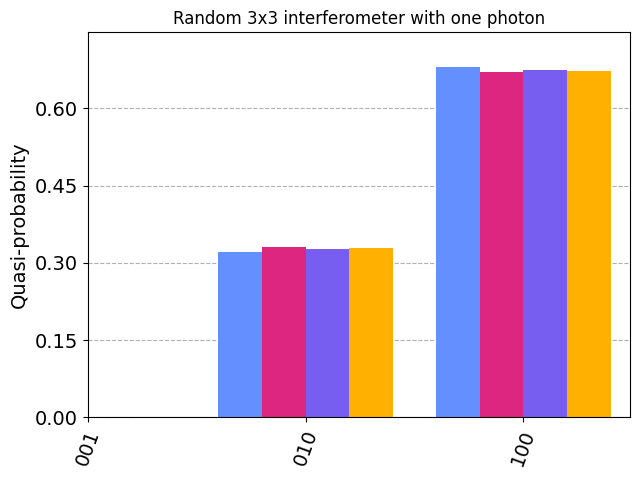

In [570]:
probs_1e3 = custom_interferom_simulation(R, initial_dist, 1e3)
probs_1e4 = custom_interferom_simulation(R, initial_dist, 1e4)
probs_1e5 = custom_interferom_simulation(R, initial_dist, 1e5)

legend = ['Shots = 1e3','Shots = 1e4','Shots = 1e5', 'Analytic results']
plot_histogram([probs_1e3, probs_1e4, probs_1e5, analytic_probs], 
               title='Random 3x3 interferometer with one photon', bar_labels=False)